#                                 MI-ZOT 

# FACE MASK DETECTION 

## ML CASE STUDY - GRP 3

### Importing the packages

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os






### initialize the initial learning rate, number of epochs to train for, and batch size

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\KAVIN\ML\Mask detection - case study\dataset"
CATEGORIES = ["with_mask", "without_mask"]



### grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images 

In [3]:
print("xxx---[INFO] loading images...---xxx")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)



xxx---[INFO] loading images...---xxx


C:\Users\KAVIN\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### perform one-hot encoding on the labels

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)



### construct the training image generator for data augmentation

In [5]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")



### load the MobileNetV2 network, ensuring the head FC layer sets areleft off

In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))



### construct the head of the model that will be placed on top of the the base model


In [7]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)



### place the headmodel on top of the base model (this will become the actual model we will train)

In [8]:

model = Model(inputs=baseModel.input, outputs=headModel)



### loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

In [9]:

for layer in baseModel.layers:
    layer.trainable = False



### compile our model

In [10]:

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])



[INFO] compiling model...


C:\Users\KAVIN\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### train the head of the network

In [11]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)



[INFO] training head...
Epoch 1/20
95/95 [==============================] - 142s 1s/step - loss: 0.4225 - accuracy: 0.8316 - val_loss: 0.1520 - val_accuracy: 0.9831
Epoch 2/20
95/95 [==============================] - 127s 1s/step - loss: 0.1463 - accuracy: 0.9621 - val_loss: 0.0735 - val_accuracy: 0.9922
Epoch 3/20
95/95 [==============================] - 126s 1s/step - loss: 0.0990 - accuracy: 0.9750 - val_loss: 0.0548 - val_accuracy: 0.9935
Epoch 4/20
95/95 [==============================] - 124s 1s/step - loss: 0.0813 - accuracy: 0.9773 - val_loss: 0.0495 - val_accuracy: 0.9870
Epoch 5/20
95/95 [==============================] - 134s 1s/step - loss: 0.0741 - accuracy: 0.9802 - val_loss: 0.0411 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 139s 1s/step - loss: 0.0615 - accuracy: 0.9802 - val_loss: 0.0365 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 139s 1s/step - loss: 0.0573 - accuracy: 0.9832 - val_loss: 0.0347 - val_accura

### make predictions on the testing set

### for each image in the testing set we need to find the index of the label with corresponding largest predicted probability

### classification report

### serialize the model to disk


In [12]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))


print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")



[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


### plot the training loss and accuracy

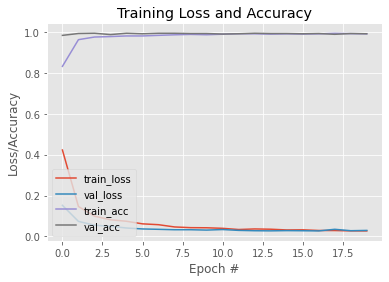

In [13]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")